In [1]:
import os

import polars as pl
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from cipred.lu2019 import lu_fit, lu_pred_prime
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
import cipred

In [3]:
cipred.__version__

'0.2-b'

# Data

Dataset providing hourly $NO_2$ measured by reference air quality stations from 2015 to 2018 in Oslo, Norway.

This dataset is embedded in this example.

This dataset has been part of peer review studies. There is **no** quality control. 

Use it **only** for research purpose.

In [4]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
data_dir = os.path.join(parent_dir,"data")

In [5]:
# read data

In [6]:
df = pl.read_csv(os.path.join(data_dir,'no2_oslo10_2015_2018.csv'),null_values='NA')

In [7]:
df = df.drop_nulls()

In [8]:
df.head()

,WDAY,YEAR,MONTH,DAY,HOUR,NO2_11,NO2_163,NO2_464,NO2_504,NO2_665,NO2_7,NO2_809,NO2_827,NO2_848,NO2_9
i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,4,2015,1,1,1,106.553432,52.929326,51.463153,59.14449,56.762501,41.609032,37.382295,49.283147,39.97828,62.58942
2,4,2015,1,1,2,78.5703,29.593088,56.232895,53.827484,43.273618,42.059002,37.933811,47.81783,40.339991,70.242064
3,4,2015,1,1,3,61.42935,25.146724,47.527457,40.016443,44.43678,42.589462,39.748719,32.161806,39.679851,67.106365
4,4,2015,1,1,4,53.817728,43.019469,47.594527,36.587882,38.527623,41.87402,38.93636,30.522687,37.712233,65.185718
5,4,2015,1,1,5,56.936825,29.362204,38.605467,26.711364,36.3755,42.248471,37.424489,30.361556,38.057995,43.592618


In [9]:
target = ['NO2_9']
predictors = ['NO2_464','NO2_827','NO2_665','NO2_7','NO2_11','NO2_163','NO2_809','NO2_504'] # 504

In [10]:
# only positive values
df = df.filter(
    (pl.col('NO2_9') > 0) & (pl.col('NO2_464') > 0) & (pl.col('NO2_827') > 0) & (pl.col('NO2_665') > 0) & (pl.col('NO2_7') > 0) & (pl.col('NO2_11') > 0) & (pl.col('NO2_163') > 0) & (pl.col('NO2_809') > 0) & (pl.col('NO2_504') > 0) 
)

In [11]:
df = df.with_columns(
    pl.struct(["YEAR","MONTH","DAY","HOUR"]).apply(lambda x: datetime.strptime("{0} {1} {2} {3}".format(x['YEAR'],x['MONTH'], x['DAY'],x['HOUR']), "%Y %m %d %H")).alias('datetime')
)

In [12]:
df.head()

,WDAY,YEAR,MONTH,DAY,HOUR,NO2_11,NO2_163,NO2_464,NO2_504,NO2_665,NO2_7,NO2_809,NO2_827,NO2_848,NO2_9,datetime
i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
1,4,2015,1,1,1,106.553432,52.929326,51.463153,59.14449,56.762501,41.609032,37.382295,49.283147,39.97828,62.58942,2015-01-01 01:00:00
2,4,2015,1,1,2,78.5703,29.593088,56.232895,53.827484,43.273618,42.059002,37.933811,47.81783,40.339991,70.242064,2015-01-01 02:00:00
3,4,2015,1,1,3,61.42935,25.146724,47.527457,40.016443,44.43678,42.589462,39.748719,32.161806,39.679851,67.106365,2015-01-01 03:00:00
4,4,2015,1,1,4,53.817728,43.019469,47.594527,36.587882,38.527623,41.87402,38.93636,30.522687,37.712233,65.185718,2015-01-01 04:00:00
5,4,2015,1,1,5,56.936825,29.362204,38.605467,26.711364,36.3755,42.248471,37.424489,30.361556,38.057995,43.592618,2015-01-01 05:00:00


In [13]:
# Training/Test period 2017-2018
train_test = df.filter(
    pl.col("datetime") >= datetime(2017, 1, 1),
)

In [14]:
#train_test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_test[predictors], train_test[target], test_size=0.2, random_state=42)

# Train/Test

In [16]:
## model
# Number of variables to possibly split at in each node: rounded down square root of the number variables. 
min_samples_split= np.floor(np.sqrt(len(predictors))).astype(np.int64)

# Minimal node size. Default 1 for classification, 5 for regression, 3 for survival,
min_samples_leaf=5

In [17]:
rf_reg = RandomForestRegressor(n_estimators = 500, 
                               min_samples_split= min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               #max_depth=4,
                               #random_state=0,
                               n_jobs=10) 

In [18]:
rf_reg, train_oob_error = lu_fit(rf_reg, X_train.to_numpy(), np.ravel(y_train.to_numpy()))

In [19]:
pred_test = lu_pred_prime(rf_reg,train_oob_error,X_test.to_numpy(),y_test.to_numpy(),0.05)

In [20]:
pred_test.head()

id,pred,obs,N0.025,N0.975,p-value
i32,f64,f64,f64,f64,f64
0,23.698917,26.285873,14.342971,31.253303,0.710235
1,28.107106,43.521019,15.014573,38.541071,0.997506
2,24.673393,22.127113,11.987846,34.380875,0.264885
3,13.940514,17.517254,8.473051,19.529271,0.915975
4,3.860591,4.016871,0.886456,5.730783,0.469953


In [21]:
# bias
np.mean((pred_test['obs'].to_numpy()-pred_test['pred'].to_numpy()))

-0.44583566179712986

In [22]:
# MAE
np.mean(np.abs(pred_test['obs'].to_numpy()-pred_test['pred'].to_numpy()))

5.699142611166269

In [23]:
metrics.r2_score(pred_test['obs'].to_numpy(),pred_test['pred'].to_numpy())

0.823082061808588

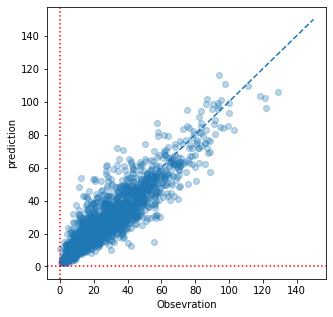

In [24]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(pred_test['obs'], pred_test['pred'], alpha=0.3)
axs.plot([0,150], [0,150], "--", label="Perfect model")
axs.set(xlabel="Obsevration",ylabel="prediction")
axs.axhline(y = 0, color = 'r', linestyle = 'dotted')
axs.axvline(x=0, color = 'r', linestyle = 'dotted')

plt.show()

In [25]:
pred_test = pred_test.sort('p-value')

U = pl.DataFrame({'U': np.linspace(0.,1.,pred_test.shape[0])})
pred_test = pl.concat((pred_test,U),how= 'horizontal')

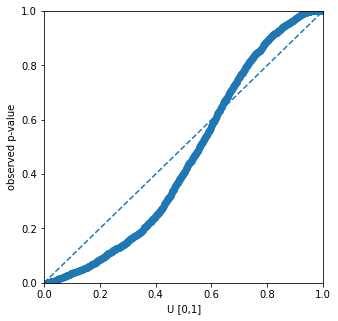

In [26]:
fig, axs = plt.subplots( figsize=(5, 5))

axs.scatter(pred_test['U'], pred_test['p-value'], alpha=0.3)
axs.plot([0,1], [0,1], "--", label="Perfect prediction")
axs.set(xlim=(0,1),ylim=(0,1),xlabel="U [0,1]",ylabel="observed p-value")
plt.show()

# Validation

In [27]:
validation = df.filter(
    pl.col("datetime") < datetime(2017, 1, 1),
)

In [28]:
X_validation = validation[predictors]
y_validation = validation[target]

In [29]:
tmp_validation = lu_pred_prime(rf_reg,train_oob_error,X_validation.to_numpy(),y_validation.to_numpy(),0.05)

In [30]:
# bias
np.mean((tmp_validation['obs'].to_numpy()-tmp_validation['pred'].to_numpy()))

2.0303654642406572

In [31]:
# MAE
np.mean(np.abs(tmp_validation['obs'].to_numpy()-tmp_validation['pred'].to_numpy()))

8.625315081911625

In [32]:
metrics.r2_score(tmp_validation['obs'].to_numpy(),tmp_validation['pred'].to_numpy())

0.7698931777896447

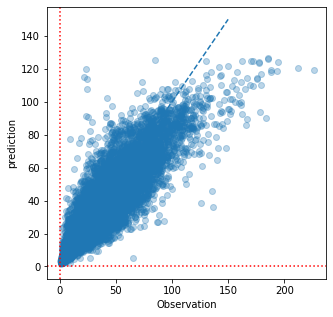

In [33]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(tmp_validation['obs'], tmp_validation['pred'], alpha=0.3)
axs.plot([0,150], [0,150], "--", label="Perfect model")
#axs.set(xlim=(0,30),ylim=(0,30),xlabel="Ref",ylabel="prediction")
axs.set(xlabel="Observation",ylabel="prediction")
axs.axhline(y = 0, color = 'r', linestyle = 'dotted')
axs.axvline(x=0, color = 'r', linestyle = 'dotted')

plt.show()

In [34]:
tmp_validation = tmp_validation.sort('p-value')

U = pl.DataFrame({'U': np.linspace(0.,1.,tmp_validation.shape[0])})
tmp_validation = pl.concat((tmp_validation,U),how= 'horizontal')

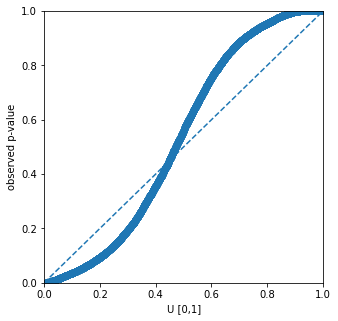

In [35]:
fig, axs = plt.subplots( figsize=(5, 5))

axs.scatter(tmp_validation['U'], tmp_validation['p-value'], alpha=0.3)
axs.plot([0,1], [0,1], "--", label="Perfect prediction")
axs.set(xlim=(0,1),ylim=(0,1),xlabel="U [0,1]",ylabel="observed p-value")
plt.show()

# Illustration

In [36]:
# conversion from polars dataframe to pandas dataframe requires pandas and pyarrow
# Pandas dataframe is used for plotting illustrations w/ matplotlib 
import pandas
import pyarrow

In [37]:
# between 4 December 2016 and 8 December 2016
illustration = df.filter(
    (pl.col("datetime") > datetime(2016, 12, 3)) & (pl.col("datetime") < datetime(2016, 12, 10)),
)

In [38]:
X_illustration = illustration[predictors]
y_illustration = illustration[target]

In [39]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration.to_numpy(),y_illustration.to_numpy(),0.05)

In [40]:
tmp_illustration = pl.concat((tmp_illustration,illustration),how='horizontal').to_pandas()

In [41]:
tmp_illustration = tmp_illustration.set_index('datetime')

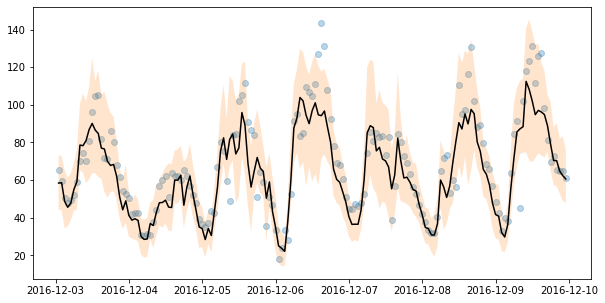

In [42]:
fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(tmp_illustration.index, 'pred', data=tmp_illustration, color='black')
axs.scatter(tmp_illustration.index, tmp_illustration['obs'].values,alpha=0.3)
axs.fill_between(tmp_illustration.index, tmp_illustration['N0.025'], tmp_illustration['N0.975'], alpha=0.2)

plt.show()

# Illustration 2

In [43]:
illustration = df.filter(
    (pl.col("datetime") < datetime(2017, 1, 1)),
)

In [44]:
X_illustration = illustration[predictors]
y_illustration = illustration[target]

In [45]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration.to_numpy(),y_illustration.to_numpy(),0.05)

In [46]:
tmp_illustration = pl.concat((tmp_illustration,illustration),how='horizontal').to_pandas()

In [47]:
#tmp_illustration[tmp_illustration['obs']>200] #7131,7132
id_il = 7131
tmp_illustration = tmp_illustration.loc[id_il-6*24:id_il+6*24,:]

In [48]:
tmp_illustration = tmp_illustration.set_index('datetime')

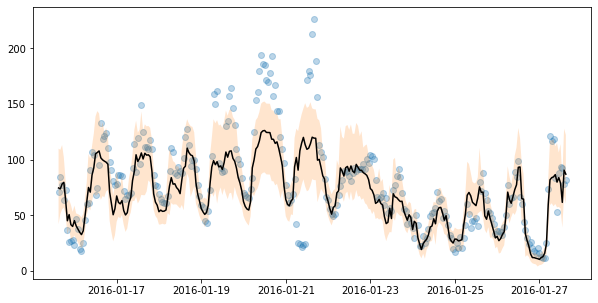

In [49]:
fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(tmp_illustration.index, 'pred', data=tmp_illustration, color='black')
axs.scatter(tmp_illustration.index, tmp_illustration['obs'].values,alpha=0.3)
axs.fill_between(tmp_illustration.index, tmp_illustration['N0.025'], tmp_illustration['N0.975'], alpha=0.2)
plt.show()